In [1]:
import os
import pandas as pd

# Drawing plots
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.metrics import confusion_matrix

# Load helper functions
from mlutils.missing_data import *

In [2]:
# defaults

#  Uses all available CPU cores
os.environ["OMP_NUM_THREADS"] = str(os.cpu_count())
os.environ["MKL_NUM_THREADS"] = str(os.cpu_count())

# Set the display option to show all rows and columns
pd.set_option('display.max_columns', None)  # To show all columns
pd.set_option('display.max_rows', None)     # To show all rows (optional)
pd.set_option('display.width', None)        # To avoid line truncation

graph_color = "cadetblue"
directory = "../datasets/original_BCCC-CIC-IDS-2017/"

In [3]:
# List all .csv files
csv_files = [f for f in os.listdir(directory) if f.endswith('.csv') and os.path.isfile(os.path.join(directory, f))]
print(len(csv_files))

18


## Loop across the csv files to to create a dataset out of all csv files to inspect the original dataset

In [4]:
length_csv = len(csv_files)
original_df = pd.DataFrame()


for i in range(0,length_csv):
    file = directory + csv_files[i]
    df = pd.read_csv(file, low_memory=False)

    # Merge
    original_df = pd.concat([df, original_df], ignore_index=True)
    

In [5]:
original_df['label'].value_counts(normalize = True)

label
Benign               0.732650
DoS_Hulk             0.143246
Port_Scan            0.066169
DDoS_LOIT            0.039266
FTP-Patator          0.003909
DoS_GoldenEye        0.003431
DoS_Slowhttptest     0.002814
SSH-Patator          0.002440
Botnet_ARES          0.002259
DoS_Slowloris        0.002123
Web_Brute_Force      0.001121
Web_XSS              0.000557
Web_SQL_Injection    0.000010
Heartbleed           0.000005
Name: proportion, dtype: float64

In [6]:
original_df['label'].value_counts()

label
Benign               1786239
DoS_Hulk              349240
Port_Scan             161323
DDoS_LOIT              95733
FTP-Patator             9531
DoS_GoldenEye           8364
DoS_Slowhttptest        6860
SSH-Patator             5949
Botnet_ARES             5508
DoS_Slowloris           5177
Web_Brute_Force         2734
Web_XSS                 1358
Web_SQL_Injection         24
Heartbleed                12
Name: count, dtype: int64

In [7]:
# Convert 'timestamp' column to datetime
original_df['timestamp'] = pd.to_datetime(original_df['timestamp'], errors='coerce')

# Extract unique days
unique_days = original_df['timestamp'].dt.date.unique()

# Create a new 'day' column by extracting the date from 'timestamp'
original_df['day'] = original_df['timestamp'].dt.day_name()


# Count the number of 'Benign' samples
benign_count = (original_df['label'] == 'Benign').sum()

# Count the number of attack samples (anything not 'Benign')
attack_count = len(original_df) - benign_count


In [8]:

# Create a pivot table counting occurrences of each label per day
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
label_day_table = original_df.pivot_table(index='label', columns='day', aggfunc='size', fill_value=0)

# Reorder columns based on the custom day order
label_day_table = label_day_table[ordered_days]

# Print the table
print(label_day_table)

# Drop day column
original_df = original_df.drop(columns=['day'])

# Calculate number of feature
num_features = original_df.shape[1] - ('label' in original_df.columns)


day                Monday  Tuesday  Wednesday  Thursday  Friday
label                                                          
Benign             495337   395974     397053    133770  364102
Botnet_ARES             0        0          0         0    5508
DDoS_LOIT               0        0          0         0   95733
DoS_GoldenEye           0        0       8364         0       0
DoS_Hulk                0        0     349240         0       0
DoS_Slowhttptest        0        0       6860         0       0
DoS_Slowloris           0        0       5177         0       0
FTP-Patator             0     9531          0         0       0
Heartbleed              0        0         12         0       0
Port_Scan               0        0          0         0  161323
SSH-Patator             0     5949          0         0       0
Web_Brute_Force         0        0          0      2734       0
Web_SQL_Injection       0        0          0        24       0
Web_XSS                 0        0      

In [9]:
print(f"Total samples: {len(original_df):,}")
print(f"Benign samples: {benign_count:,}")
print(f"Attack samples: {attack_count:,}")
print("Number of features:", num_features)

Total samples: 2,438,052
Benign samples: 1,786,239
Attack samples: 651,813
Number of features: 121


## Loop across the csv files to extrat only http(s) DDoS attacks and create a dataset out of all csv files

In [10]:
length_csv = len(csv_files)
only_http_https_df = pd.DataFrame()


for i in range(0,length_csv):
    file = directory + csv_files[i]
    df = pd.read_csv(file, low_memory=False)

    # Get unique HTTP port (80) & HTTPS port (443)
    unique_Destination_Port_80_443 = df.loc[df['dst_port'].isin([80, 443])]
    
    # Merge
    only_http_https_df = pd.concat([unique_Destination_Port_80_443, only_http_https_df], ignore_index=True)
    

In [11]:
# Drop instances that are not DDoS atacks
dos_attack_labels = ['DoS_GoldenEye', 'DoS_Hulk', 'DDoS_LOIT', 'DoS_Slowhttptest', 'DoS_Slowloris', 'Benign']
# Filter rows where 'label' is one of the valid labels
only_http_https_df = only_http_https_df[only_http_https_df['label'].isin(dos_attack_labels)]


In [12]:
only_http_https_df['label'].value_counts(normalize = True)

label
Benign              0.647859
DoS_Hulk            0.252412
DDoS_LOIT           0.083813
DoS_GoldenEye       0.006863
DoS_Slowhttptest    0.004909
DoS_Slowloris       0.004144
Name: proportion, dtype: float64

In [13]:
only_http_https_df['label'].value_counts()

label
Benign              730734
DoS_Hulk            284701
DDoS_LOIT            94535
DoS_GoldenEye         7741
DoS_Slowhttptest      5537
DoS_Slowloris         4674
Name: count, dtype: int64

In [14]:
# Convert 'timestamp' column to datetime
only_http_https_df['timestamp'] = pd.to_datetime(only_http_https_df['timestamp'], errors='coerce')

# Extract unique days
unique_days = only_http_https_df['timestamp'].dt.date.unique()

# Create a new 'day' column by extracting the date from 'timestamp'
only_http_https_df['day'] = only_http_https_df['timestamp'].dt.day_name()


# Count the number of 'Benign' samples
benign_count = (only_http_https_df['label'] == 'Benign').sum()

# Count the number of attack samples (anything not 'Benign')
attack_count = len(only_http_https_df) - benign_count


In [15]:
# Create a pivot table counting occurrences of each label per day
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
label_day_table = only_http_https_df.pivot_table(index='label', columns='day', aggfunc='size', fill_value=0)

# Reorder columns based on the custom day order
label_day_table = label_day_table[ordered_days]

# Print the table
print(label_day_table)

# Drop day column
only_http_https_df = only_http_https_df.drop(columns=['day'])

# Calculate number of feature
num_features = only_http_https_df.shape[1] - ('label' in only_http_https_df.columns)

day               Monday  Tuesday  Wednesday  Thursday  Friday
label                                                         
Benign            222788   163013     157778     52026  135128
DDoS_LOIT              0        0          0         0   94535
DoS_GoldenEye          0        0       7741         0       0
DoS_Hulk               0        0     284701         0       0
DoS_Slowhttptest       0        0       5537         0       0
DoS_Slowloris          0        0       4674         0       0


In [16]:
print(f"Total samples: {len(only_http_https_df):,}")
print(f"Benign samples: {benign_count:,}")
print(f"Attack samples: {attack_count:,}")
print("Number of features:", num_features)


Total samples: 1,127,922
Benign samples: 730,734
Attack samples: 397,188
Number of features: 121


In [19]:
total_benign = only_http_https_df[only_http_https_df['label'] == 'Benign'].shape[0]
total_DDoS_LOIT = only_http_https_df[only_http_https_df['label'] == 'DDoS_LOIT'].shape[0]
total_DoS_GoldenEye = only_http_https_df[only_http_https_df['label'] == 'DoS_GoldenEye'].shape[0]
total_DoS_Hulk = only_http_https_df[only_http_https_df['label'] == 'DoS_Hulk'].shape[0]
total_DoS_Slowhttptest = only_http_https_df[only_http_https_df['label'] == 'DoS_Slowhttptest'].shape[0]
total_DoS_Slowloris = only_http_https_df[only_http_https_df['label'] == 'DoS_Slowloris'].shape[0]

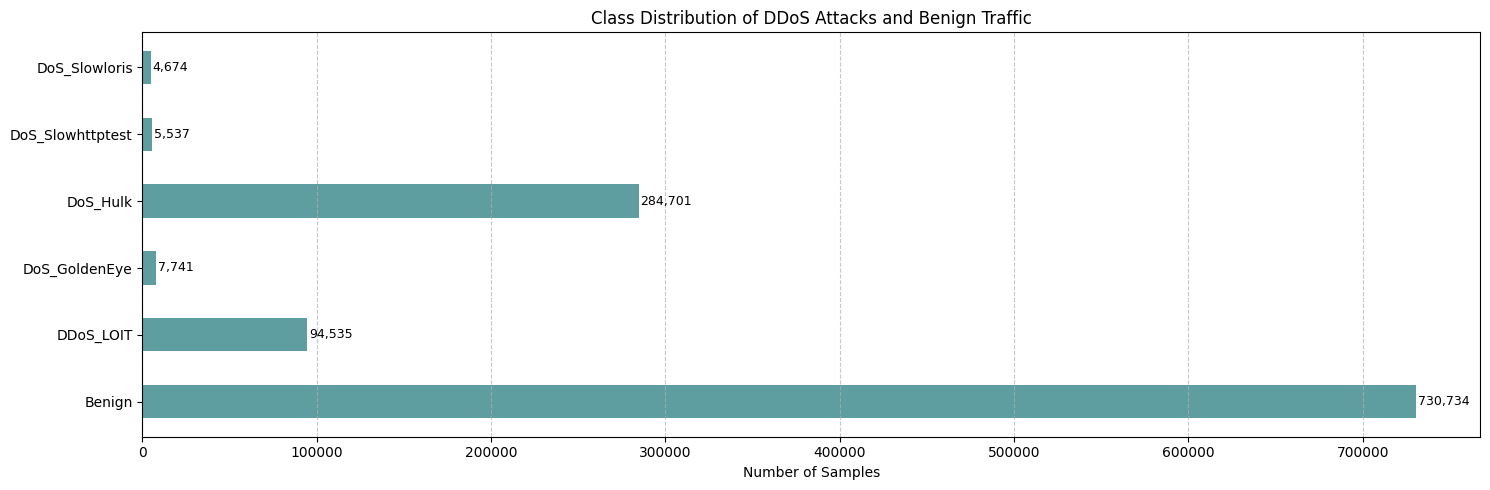

In [ ]:
# Prepare the data
data = {
    'Class': [
        'Benign',
        'DDoS_LOIT',
        'DoS_GoldenEye',
        'DoS_Hulk',
        'DoS_Slowhttptest',
        'DoS_Slowloris'
    ],
    'Count': [
        total_benign,
        total_DDoS_LOIT,
        total_DoS_GoldenEye,
        total_DoS_Hulk,
        total_DoS_Slowhttptest,
        total_DoS_Slowloris
    ]
}

df = pd.DataFrame(data)

# Plot horizontal bar chart with narrower bars and value annotations
plt.figure(figsize=(15, 5))
bars = plt.barh(df['Class'], df['Count'], color='cadetblue', height=0.5)
plt.xlabel('Number of Samples')
plt.title('Class Distribution of HTTP DDoS Attacks and Benign Traffic')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add text labels to the bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 1000, bar.get_y() + bar.get_height() / 2,
             f'{int(width):,}', va='center', fontsize=9)

plt.tight_layout()
plt.show()


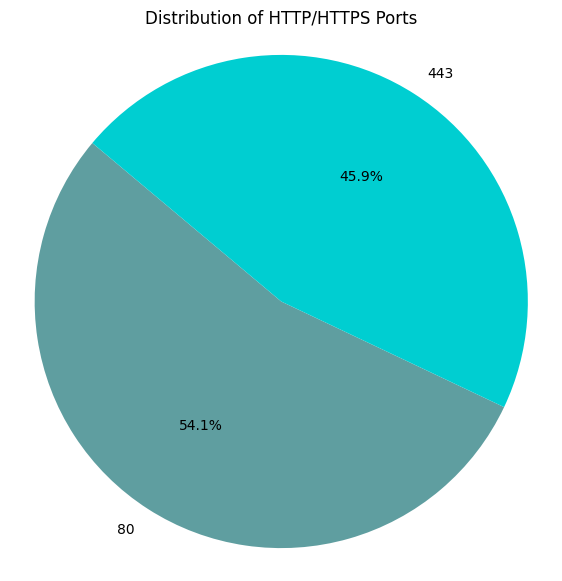

In [35]:
# Visualize Destination_Port distribution
port_counts = only_http_https_df['dst_port'].value_counts()
plt.figure(figsize=(7, 7))
plt.pie(port_counts, labels=port_counts.index, autopct='%1.1f%%', startangle=140, colors=[graph_color, 'darkturquoise'])
plt.title("Distribution of HTTP/HTTPS Ports")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show plot
plt.show()

In [36]:
# # Saving the DataFrame to a CSV file
only_http_https_df.to_csv(f'{directory}/subsets/original_only_http_https_attacks_port_80_and_443.csv', index=False)  # index=False prevents writing row numbers

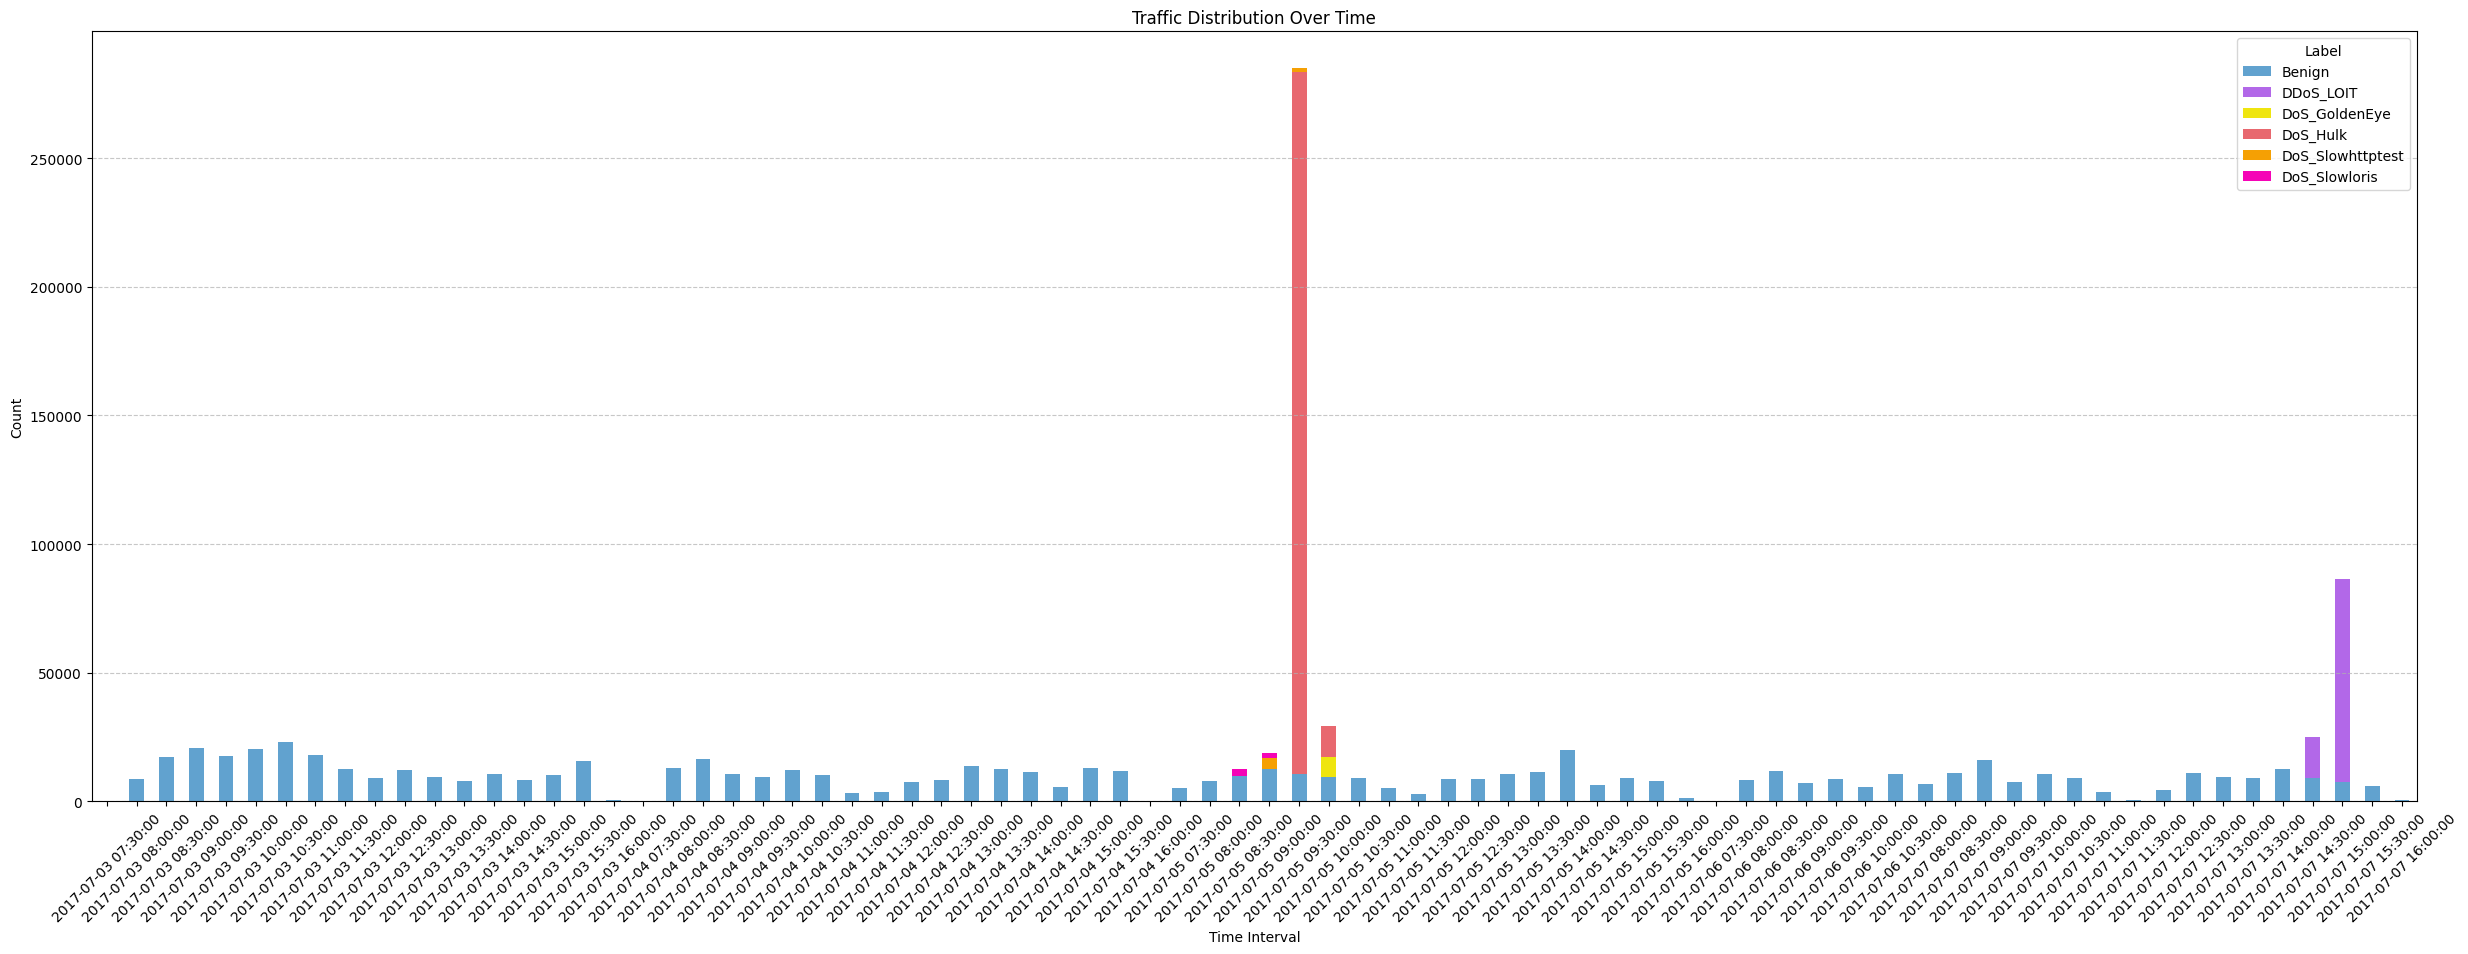

In [34]:
only_http_https_df['timestamp_datetime'] = pd.to_datetime(only_http_https_df['timestamp'], unit='ns')

# Define time bin size (e.g., 10 minutes)
only_http_https_df['time_bin'] = only_http_https_df['timestamp_datetime'].dt.floor('30min')  # Floor to nearest 10-minute interval

# Count occurrences of labels per time bin
grouped = only_http_https_df.groupby(['time_bin', 'label']).size().unstack(fill_value=0)

# Define colors (Benign → Blue, Others → Different Colors)
color_map = {
    'Benign': '#61a2cf',
    'DoS_Hulk': '#e8686f',
    'DDoS_LOIT': '#b268e8',
    'DoS_GoldenEye': '#efe50f',
    'DoS_Slowhttptest': '#f5a004',
    'DoS_Slowloris': '#f504b6',
    }
default_colors = plt.get_cmap('tab10')  # Fallback colors

# Assign colors dynamically
colors = [color_map.get(label, default_colors(i)) for i, label in enumerate(grouped.columns)]

# Plot
grouped.plot(kind='bar', stacked=True, figsize=(30, 10), color=colors)


plt.xlabel("Time Interval")
plt.ylabel("Count")
plt.title("Traffic Distribution Over Time")
plt.xticks(rotation=45)
plt.legend(title="Label")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()